# Data Processing

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 50)

clinical_data = pd.read_excel("TRAIN/Training_Unlabeled_Clinical_Data.xlsx")
biomarker_data = pd.read_csv("TRAIN/Training_Biomarker_Data.csv")

# Extract Meta Data
meta = clinical_data["File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
clinical_data[meta.columns] = meta

# Fix missing meta columns
idx = clinical_data["Image_Name"].isna()
clinical_data.loc[idx, ["Folder", "Visit", "Eye", "Image_Name"]] = clinical_data.loc[idx, ["Arm", "Folder", "Visit", "Eye"]].values
clinical_data.loc[idx, "Arm"] = None

columns = biomarker_data.columns.tolist()
columns[0] = clinical_data.columns[0]
biomarker_data.columns = columns

biomarker_clinical = pd.merge(biomarker_data, clinical_data, on="File_Path", how="left")

missing_idx = lambda x: x["Eye_ID"].isna()

meta = biomarker_clinical.loc[missing_idx, "File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Folder", "Visit", "Eye", "Image_Name"]
biomarker_clinical.loc[missing_idx, meta.columns] = meta

biomarker_clinical.loc[missing_idx, "Eye_ID"] = 79
biomarker_clinical = biomarker_clinical.drop(['Patient_ID', 'BCVA', 'CST'], axis = 1)
biomarker_clinical["File_Path"] = "TRAIN/OLIVES" + biomarker_clinical["File_Path"]

In [2]:
test_df = pd.read_csv('test_set_labels.csv')
columns = test_df.columns.tolist()
columns[0] = clinical_data.columns[0]
test_df.columns = columns

test_df["File_Path"] = "/" + test_df["File_Path"]
#meta = test_df["File_Path"].str.split("/", expand=True)
#meta = meta.drop(0, axis=1)
#meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
#test_df[meta.columns] = meta
test_df["File_Path"] = "TEST" + test_df["File_Path"]

In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

labels = ["B1", "B2", "B3", "B4", "B5", "B6"]

eye_ids = biomarker_clinical.groupby("Eye_ID")[["B1", "B2", "B3", "B4", "B5", "B6"]].mean().round().astype(int)

mskf = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=3000)

train_index, test_index = next(iter(mskf.split(eye_ids.index, eye_ids)))

In [4]:
train_ids, val_ids = eye_ids.index[train_index], eye_ids.index[test_index]
train_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(train_ids), ["File_Path"] + labels]
val_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(val_ids), ["File_Path"] + labels]

In [5]:
import numpy as np
filtered_values = np.where((test_df['B1'] == 0) & (test_df['B2'] == 1))

In [6]:
filtered_test_df = test_df.loc[filtered_values]

In [7]:
train_df = pd.concat([train_df, filtered_test_df])

In [8]:
train_df["B1"].value_counts(), train_df["B2"].value_counts(), train_df["B3"].value_counts(), train_df["B4"].value_counts(), train_df["B5"].value_counts(), train_df["B6"].value_counts()

(1    5525
 0    3568
 Name: B1, dtype: int64,
 0    5616
 1    3477
 Name: B2, dtype: int64,
 1    4628
 0    4465
 Name: B3, dtype: int64,
 0    6396
 1    2697
 Name: B4, dtype: int64,
 0    6434
 1    2659
 Name: B5, dtype: int64,
 0    5497
 1    3596
 Name: B6, dtype: int64)

In [9]:
biomarker_clinical["B1"].value_counts(), biomarker_clinical["B2"].value_counts(), biomarker_clinical["B3"].value_counts(), biomarker_clinical["B4"].value_counts(), biomarker_clinical["B5"].value_counts(), biomarker_clinical["B6"].value_counts()

(1    6341
 0    3067
 Name: B1, dtype: int64,
 0    6424
 1    2984
 Name: B2, dtype: int64,
 1    5222
 0    4186
 Name: B3, dtype: int64,
 0    6572
 1    2836
 Name: B4, dtype: int64,
 0    6405
 1    3003
 Name: B5, dtype: int64,
 0    5320
 1    4088
 Name: B6, dtype: int64)

In [10]:
import torch
pos_weight_one = 3067/6371
pos_weight_two = 6424/2984
pos_weight_three = 4186/5222
pos_weight_four = 6572/2836
pos_weight_five = 6405/3003
pos_weight_six = 5320/4088
pos_weight = torch.tensor([pos_weight_one, pos_weight_two, pos_weight_three, pos_weight_four, pos_weight_five, pos_weight_six])

# Initialization

In [11]:
%matplotlib inline
from PIL import Image
import torch.utils.data as data
import os
import math
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torchsummary import summary
import torch
import torchvision
from sklearn.metrics import accuracy_score
# import skimage
from skimage.io import imread
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import time
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics

In [12]:
import os
import random

import numpy as np
import torch

SEED = 3000

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
from __future__ import print_function

import math
import numpy as np
import torch
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

# Data Loader 

In [15]:
class OLIVES(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor

In [16]:
normalize = transforms.Normalize(mean=.1706, std=.2112)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])
val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.ToTensor(),
        normalize,
    ])

In [17]:
train_dataset = OLIVES(train_df, transforms = train_transform)
validation_dataset = OLIVES(val_df, transforms = val_transform)

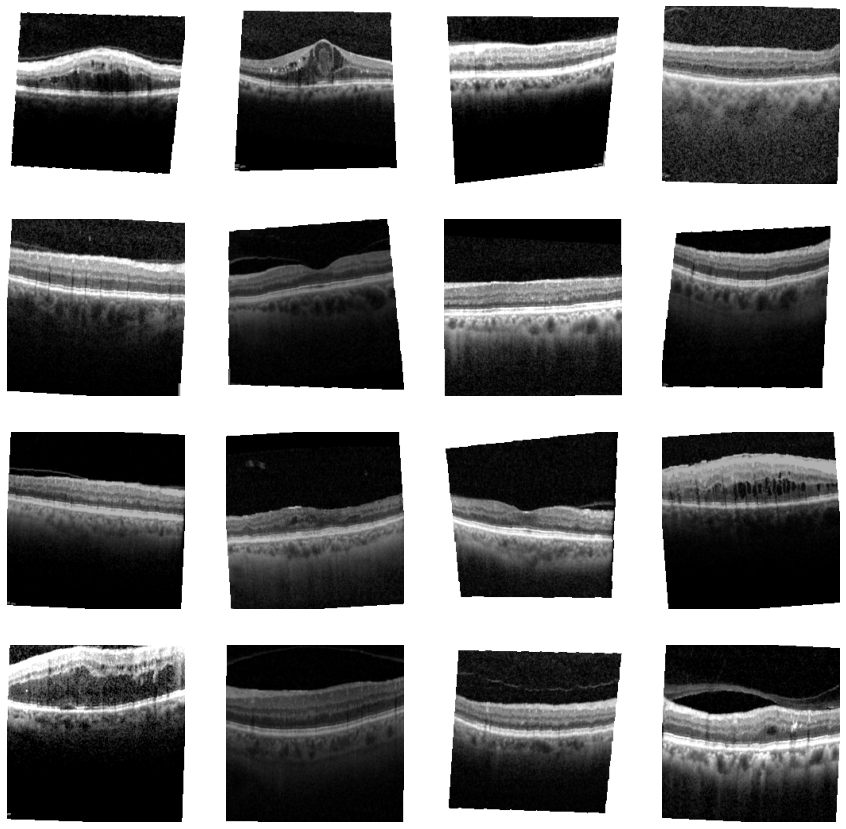

In [18]:
# Plot more images
torch.manual_seed(SEED)
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False);

In [19]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True)

# Device

In [20]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model 

In [21]:
model = torchvision.models.resnet50(weights=None,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

# Criterion, Optimizer

In [1]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

NameError: name 'torch' is not defined

# Balanced accuracy score

In [23]:
from sklearn.metrics import balanced_accuracy_score

def compute_balanced_accuracy(truths, outputs):
    
    return [
        round(balanced_accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [24]:
def compute_accuracy_score(truths, outputs):
    
    return [
        round(accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [25]:
def compute_sensitivity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [26]:
def compute_specificity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred, pos_label=0), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [27]:
def custom_metric(x, y):
    x = np.transpose(x)
    y = np.transpose(y)
    
    return [
        round((2*(a*b)/(a+b)).item(), 4)
        for a, b in zip(x, y)
    ]

# Training

In [28]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True)

In [30]:
# training routine
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

epochs = 100
t_loss = []
v_loss = []
accur = []
bal_accur = []
custom = []
s1 = []
s2 = []
for epoch in range(1, epochs + 1):
    # train
    model.train()
    #classifier.train()
    Train_losses = AverageMeter()
    
    for idx, (image, bio_tensor) in enumerate(train_loader):
        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss


        #features = model(images)
        output = model(images)
        
        loss = criterion(output, labels)
        
        # update metric
        Train_losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Val_losses = AverageMeter()
    y_true = []
    y_pred = []
    model.eval()
    #classifier.eval()    
    for idx, (image, bio_tensor) in enumerate(validation_loader):
        # Validation

        with torch.inference_mode():
            images = image.to(device)

            labels = bio_tensor.float()

            labels = labels.to(device)
            bsz = labels.shape[0]

            # compute loss


            #features = model(images)
            output = model(images)
            loss = criterion(output, labels)
            
            
            output = torch.round(torch.sigmoid(output))
            output = output.squeeze().detach().cpu().numpy()
            labels = labels.squeeze().detach().cpu().numpy()
            y_true.append(labels)
            y_pred.append(output)
            Val_losses.update(loss.item(), bsz)
    
    test_true = np.transpose(y_true)
    test_pred = np.transpose(y_pred)
    acc = compute_accuracy_score(test_true, test_pred)
    balanced_acc = compute_balanced_accuracy(test_true, test_pred)
    sen = compute_sensitivity(test_true, test_pred)
    spe = compute_specificity(test_true, test_pred)
    cus_met = custom_metric(sen, spe)
    
    t_loss.append(Train_losses.avg)
    v_loss.append(Val_losses.avg)
    accur.append(np.mean(acc))
    bal_accur.append(np.mean(balanced_acc))
    custom.append(np.mean(cus_met))
    s1.append(np.mean(sen))
    s2.append(np.mean(spe))
    print('-' * 10)
    print(f"{epoch}/{epochs}")
    print(f"Train loss: {Train_losses.avg:.5f} | Validation loss: {Val_losses.avg:.5f}")
    print(f"Accuracy: {acc} | Mean Accuracy: {np.mean(acc):.5f}")       
    print("Balanced acc (val): {} | Mean Balanced acc (val): {:.4f}".format(balanced_acc, np.mean(balanced_acc)))
    print(f"Sensitivity: {sen} | Mean Sensitivity: {np.mean(sen):.5f}")
    print(f"Specificity: {spe} | Mean Specificity: {np.mean(spe):.5f}")
    print(f"Custom Metric: {cus_met} | Mean Custom Metric: {np.mean(cus_met):.5f}")
    print('-' * 10)
    if epoch % 1 == 0:
        MODEL_NAME = f"18_vip_cup_teacher_random_weight_epoch_{epoch}.pth"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        state = {'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'epoch': epoch,
                }
        # Save the model state dict
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(state,
                   f=MODEL_SAVE_PATH)
        del state      

----------
1/100
Train loss: 0.74579 | Validation loss: 0.65821
Accuracy: [0.619, 0.4719, 0.5527, 0.3248, 0.8359, 0.8104] | Mean Accuracy: 0.60245
Balanced acc (val): [0.7115, 0.5144, 0.5539, 0.5265, 0.8218, 0.8068] | Mean Balanced acc (val): 0.6558
Sensitivity: [[0.473, 0.6277, 0.4377, 0.9879, 0.7855, 0.7668]] | Mean Sensitivity: 0.67977
Specificity: [[0.95, 0.401, 0.6701, 0.0651, 0.858, 0.8469]] | Mean Specificity: 0.63185
Custom Metric: [0.6316, 0.4894, 0.5295, 0.1222, 0.8202, 0.8049] | Mean Custom Metric: 0.56630
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_1.pth
----------
2/100
Train loss: 0.64283 | Validation loss: 0.66448
Accuracy: [0.6003, 0.3223, 0.5706, 0.7185, 0.8546, 0.8197] | Mean Accuracy: 0.64767
Balanced acc (val): [0.7081, 0.5068, 0.573, 0.5, 0.8298, 0.8094] | Mean Balanced acc (val): 0.6545
Sensitivity: [[0.4301, 1.0, 0.3401, 0.0, 0.766, 0.6922]] | Mean Sensitivity: 0.53807
Specificity: [[0.9861, 0.0136, 0.8058, 1.0, 0.8935, 0.9266]] | Me

----------
15/100
Train loss: 0.45455 | Validation loss: 0.55356
Accuracy: [0.7543, 0.7636, 0.7381, 0.7577, 0.8435, 0.8707] | Mean Accuracy: 0.78798
Balanced acc (val): [0.7717, 0.6785, 0.7374, 0.6283, 0.8421, 0.8709] | Mean Balanced acc (val): 0.7548
Sensitivity: [[0.7267, 0.4511, 0.803, 0.3323, 0.8384, 0.8731]] | Mean Sensitivity: 0.67077
Specificity: [[0.8167, 0.9059, 0.6718, 0.9243, 0.8458, 0.8688]] | Mean Specificity: 0.83888
Custom Metric: [0.7691, 0.6023, 0.7316, 0.4889, 0.8421, 0.8709] | Mean Custom Metric: 0.71748
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_15.pth
----------
16/100
Train loss: 0.43659 | Validation loss: 0.50958
Accuracy: [0.6947, 0.8231, 0.7934, 0.7619, 0.8631, 0.8733] | Mean Accuracy: 0.80158
Balanced acc (val): [0.7598, 0.7884, 0.792, 0.7241, 0.8538, 0.8677] | Mean Balanced acc (val): 0.7976
Sensitivity: [[0.5919, 0.6957, 0.9226, 0.6375, 0.8301, 0.8041]] | Mean Sensitivity: 0.74698
Specificity: [[0.9278, 0.8812, 0.6615, 0.8107, 

----------
29/100
Train loss: 0.36756 | Validation loss: 0.49684
Accuracy: [0.7398, 0.7143, 0.7687, 0.8563, 0.8707, 0.8767] | Mean Accuracy: 0.80442
Balanced acc (val): [0.7605, 0.7558, 0.7696, 0.7888, 0.8219, 0.8675] | Mean Balanced acc (val): 0.7940
Sensitivity: [[0.7071, 0.8668, 0.6818, 0.6344, 0.6964, 0.7631]] | Mean Sensitivity: 0.72493
Specificity: [[0.8139, 0.6448, 0.8574, 0.9432, 0.9474, 0.9719]] | Mean Specificity: 0.86310
Custom Metric: [0.7568, 0.7395, 0.7596, 0.7586, 0.8027, 0.8549] | Mean Custom Metric: 0.77868
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_29.pth
----------
30/100
Train loss: 0.35873 | Validation loss: 0.50590
Accuracy: [0.7117, 0.7577, 0.7781, 0.8274, 0.8776, 0.8724] | Mean Accuracy: 0.80415
Balanced acc (val): [0.7651, 0.763, 0.7779, 0.7595, 0.8393, 0.8636] | Mean Balanced acc (val): 0.7947
Sensitivity: [[0.6275, 0.7772, 0.7912, 0.6042, 0.7409, 0.7631]] | Mean Sensitivity: 0.71735
Specificity: [[0.9028, 0.7488, 0.7646, 0.9148,

----------
43/100
Train loss: 0.31626 | Validation loss: 0.53624
Accuracy: [0.7534, 0.7704, 0.7891, 0.7474, 0.8716, 0.8784] | Mean Accuracy: 0.80172
Balanced acc (val): [0.7874, 0.7323, 0.788, 0.7397, 0.842, 0.8787] | Mean Balanced acc (val): 0.7947
Sensitivity: [[0.6998, 0.6304, 0.9007, 0.7221, 0.766, 0.8825]] | Mean Sensitivity: 0.76692
Specificity: [[0.875, 0.8342, 0.6753, 0.7574, 0.918, 0.875]] | Mean Specificity: 0.82248
Custom Metric: [0.7777, 0.7181, 0.7719, 0.7393, 0.8351, 0.8787] | Mean Custom Metric: 0.78680
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_43.pth
----------
44/100
Train loss: 0.31816 | Validation loss: 0.55720
Accuracy: [0.7611, 0.7474, 0.7585, 0.7942, 0.8716, 0.8844] | Mean Accuracy: 0.80287
Balanced acc (val): [0.7844, 0.7104, 0.7568, 0.7456, 0.8529, 0.88] | Mean Balanced acc (val): 0.7883
Sensitivity: [[0.7243, 0.6114, 0.9276, 0.6344, 0.805, 0.8302]] | Mean Sensitivity: 0.75548
Specificity: [[0.8444, 0.8094, 0.5859, 0.8568, 0.9009,

----------
57/100
Train loss: 0.26669 | Validation loss: 0.58006
Accuracy: [0.79, 0.7389, 0.7696, 0.7951, 0.8793, 0.8861] | Mean Accuracy: 0.80983
Balanced acc (val): [0.8207, 0.7486, 0.7695, 0.6755, 0.853, 0.8792] | Mean Balanced acc (val): 0.7911
Sensitivity: [[0.7414, 0.7745, 0.7761, 0.4018, 0.7855, 0.8022]] | Mean Sensitivity: 0.71358
Specificity: [[0.9, 0.7228, 0.7629, 0.9491, 0.9204, 0.9562]] | Mean Specificity: 0.86857
Custom Metric: [0.813, 0.7478, 0.7694, 0.5646, 0.8476, 0.8725] | Mean Custom Metric: 0.76915
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_57.pth
----------
58/100
Train loss: 0.26064 | Validation loss: 0.57074
Accuracy: [0.7747, 0.7696, 0.7755, 0.7815, 0.8793, 0.8861] | Mean Accuracy: 0.81112
Balanced acc (val): [0.805, 0.7472, 0.7747, 0.6789, 0.8623, 0.8811] | Mean Balanced acc (val): 0.7915
Sensitivity: [[0.7267, 0.6875, 0.8519, 0.4441, 0.8189, 0.8246]] | Mean Sensitivity: 0.72562
Specificity: [[0.8833, 0.8069, 0.6976, 0.9136, 0.9058

----------
71/100
Train loss: 0.22860 | Validation loss: 0.67494
Accuracy: [0.7594, 0.7415, 0.7543, 0.8044, 0.8878, 0.8844] | Mean Accuracy: 0.80530
Balanced acc (val): [0.8018, 0.7571, 0.7541, 0.7031, 0.8552, 0.878] | Mean Balanced acc (val): 0.7915
Sensitivity: [[0.6924, 0.7989, 0.7727, 0.4713, 0.7716, 0.806]] | Mean Sensitivity: 0.71882
Specificity: [[0.9111, 0.7153, 0.7354, 0.9349, 0.9388, 0.95]] | Mean Specificity: 0.86425
Custom Metric: [0.7868, 0.7548, 0.7536, 0.6267, 0.847, 0.8721] | Mean Custom Metric: 0.77350
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_71.pth
----------
72/100
Train loss: 0.22503 | Validation loss: 0.62705
Accuracy: [0.7151, 0.7764, 0.7619, 0.7636, 0.8818, 0.8793] | Mean Accuracy: 0.79635
Balanced acc (val): [0.787, 0.8136, 0.7624, 0.7234, 0.8572, 0.8759] | Mean Balanced acc (val): 0.8032
Sensitivity: [[0.6017, 0.913, 0.7138, 0.6314, 0.7939, 0.8377]] | Mean Sensitivity: 0.74858
Specificity: [[0.9722, 0.7141, 0.811, 0.8154, 0.9204

----------
85/100
Train loss: 0.19995 | Validation loss: 0.65824
Accuracy: [0.733, 0.699, 0.7594, 0.7543, 0.8844, 0.841] | Mean Accuracy: 0.77852
Balanced acc (val): [0.7851, 0.7521, 0.7599, 0.7288, 0.866, 0.8391] | Mean Balanced acc (val): 0.7885
Sensitivity: [[0.6507, 0.894, 0.702, 0.6707, 0.8189, 0.8172]] | Mean Sensitivity: 0.75892
Specificity: [[0.9194, 0.6101, 0.8179, 0.787, 0.9131, 0.8609]] | Mean Specificity: 0.81807
Custom Metric: [0.7621, 0.7253, 0.7555, 0.7242, 0.8634, 0.8385] | Mean Custom Metric: 0.77817
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_85.pth
----------
86/100
Train loss: 0.19980 | Validation loss: 0.66156
Accuracy: [0.7645, 0.7611, 0.7645, 0.7058, 0.8793, 0.8699] | Mean Accuracy: 0.79085
Balanced acc (val): [0.8101, 0.7891, 0.7645, 0.7117, 0.8655, 0.8682] | Mean Balanced acc (val): 0.8015
Sensitivity: [[0.6924, 0.8641, 0.7559, 0.7251, 0.8301, 0.8489]] | Mean Sensitivity: 0.78608
Specificity: [[0.9278, 0.7141, 0.7732, 0.6982, 0.900

----------
99/100
Train loss: 0.17446 | Validation loss: 0.75811
Accuracy: [0.7645, 0.7321, 0.744, 0.7866, 0.8844, 0.8631] | Mean Accuracy: 0.79578
Balanced acc (val): [0.807, 0.7318, 0.7434, 0.6925, 0.8793, 0.8618] | Mean Balanced acc (val): 0.7860
Sensitivity: [[0.6973, 0.731, 0.803, 0.4773, 0.8663, 0.847]] | Mean Sensitivity: 0.73698
Specificity: [[0.9167, 0.7327, 0.6838, 0.9077, 0.8923, 0.8766]] | Mean Specificity: 0.83497
Custom Metric: [0.7921, 0.7318, 0.7386, 0.6256, 0.8791, 0.8615] | Mean Custom Metric: 0.77145
----------
Saving model to: models\18_vip_cup_teacher_random_weight_epoch_99.pth
----------
100/100
Train loss: 0.17522 | Validation loss: 0.71363
Accuracy: [0.716, 0.7007, 0.7355, 0.8027, 0.8835, 0.8682] | Mean Accuracy: 0.78443
Balanced acc (val): [0.7837, 0.7496, 0.7362, 0.701, 0.8748, 0.8675] | Mean Balanced acc (val): 0.7855
Sensitivity: [[0.6091, 0.8804, 0.67, 0.4683, 0.8524, 0.8601]] | Mean Sensitivity: 0.72338
Specificity: [[0.9583, 0.6188, 0.8024, 0.9337, 0.8972

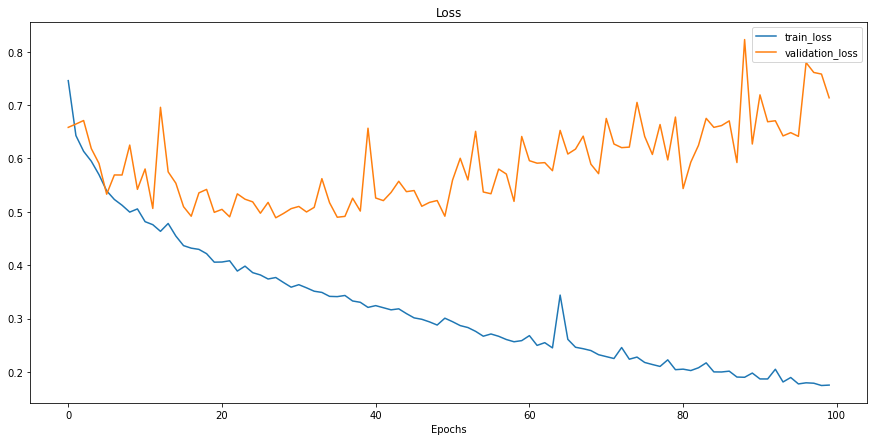

In [31]:
plt.figure(figsize=(15, 7))

    # Plot loss
plt.plot(range(len(t_loss)), t_loss, label='train_loss')
plt.plot(range(len(v_loss)), v_loss, label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

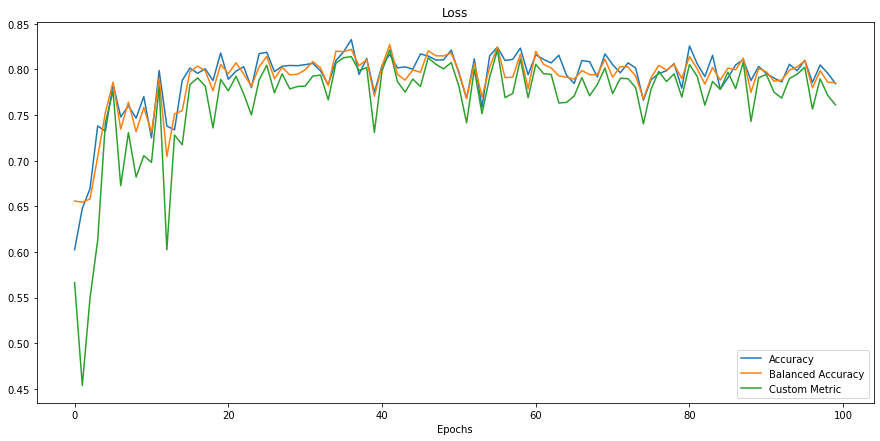

In [32]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(accur)), accur, label='Accuracy')
plt.plot(range(len(bal_accur)), bal_accur, label='Balanced Accuracy')
plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

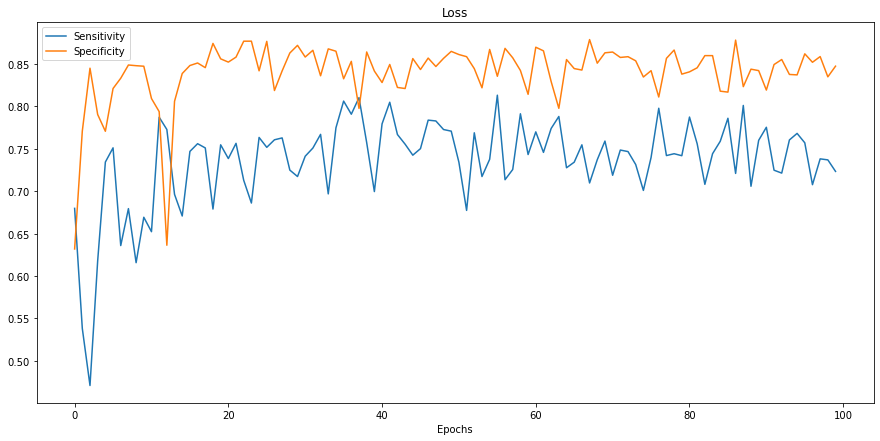

In [33]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(s1)), s1, label='Sensitivity')
plt.plot(range(len(s2)), s2, label='Specificity')
#plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [57]:
ckpt = torch.load("models/18_vip_cup_teacher_random_weight_epoch_36.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-4.8281e-02, -3.8351e-02, -4.8044e-02,  ..., -8.9726e-02,
                         -2.9272e-03,  2.1134e-02],
                        [ 5.6995e-02, -2.2833e-01, -7.0894e-02,  ..., -1.1651e-01,
                         -9.5782e-02, -1.6279e-01],
                        [ 6.3213e-02, -1.8363e-01, -1.4768e-01,  ..., -1.3087e-02,
                          3.4222e-02, -1.1728e-01],
                        ...,
                        [-2.7974e-03,  6.7405e-02,  2.1407e-02,  ..., -6.0889e-02,
                         -1.3941e-02,  2.9224e-04],
                        [-6.3311e-02, -2.6827e-02,  2.4868e-02,  ...,  1.8070e-01,
                          5.2560e-04, -8.2158e-02],
                        [ 8.3267e-02,  1.5926e-01,  2.2023e-01,  ...,  2.2072e-01,
                          1.7100e-01,  1.8498e-01]]],
              
              
                      [[[ 6.5558e-02,  1.2430e-01,  1.9836e-02,  ..., -8.3944e-02,
                

In [58]:
test_csv_path = 'TEST/test_set_submission_template.csv'
test_image_path = 'TEST/'

In [59]:
class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image, idx

In [60]:
test_dataset = RECOVERY(test_csv_path, test_image_path, val_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True,drop_last=False)

In [61]:
submission = pd.read_csv(test_csv_path)

In [62]:
model.eval()
with torch.no_grad():
    for idx, (image, index) in (enumerate(test_dataloader)):
        images = image.float().to(device)
        output = model(images)
        output = torch.round(torch.sigmoid(output))
        output = output.squeeze().cpu().numpy()
        index = int(index.numpy()[0])
        submission.iloc[index, 1:] = output

In [63]:
submission.to_csv('sub_eighteen.csv', index=None)